In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets  # interactive display
from scipy.stats import poisson

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("../JC.mplstyle")


In [34]:
def plot_value_function(value_function):
    x = np.arange(1, 11)
    y = np.arange(12, 22)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(16, 8))

    # Plot value function without usable ace
    ax1 = fig.add_subplot(121, projection='3d')
    Z1 = value_function[:, :, 0]
    ax1.plot_surface(X, Y, Z1, cmap='viridis')
    ax1.set_title('No Usable Ace')
    ax1.set_xlabel('Dealer Upcard')
    ax1.set_ylabel('Player Total')
    ax1.set_zlabel('Value')
    ax1.set_zlim(-1, 1)

    # Plot value function with usable ace
    ax2 = fig.add_subplot(122, projection='3d')
    Z2 = value_function[:, :, 1]
    ax2.plot_surface(X, Y, Z2, cmap='viridis')
    ax2.set_title('Usable Ace')
    ax2.set_xlabel('Dealer Upcard')
    ax2.set_ylabel('Player Total')
    ax2.set_zlabel('Value')
    ax2.set_zlim(-1, 1)

    plt.show()

def plot_policy(policy):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    actions = ['S', 'H']

    for idx, usable_ace in enumerate([False, True]):
        ax[idx].imshow(policy[:, :, int(usable_ace)], cmap='viridis', origin='lower')
        ax[idx].set_xticks(range(10))
        ax[idx].set_yticks(range(10))
        ax[idx].set_xticklabels(range(1, 11))
        ax[idx].set_yticklabels(range(12, 22))
        ax[idx].set_xlabel("Dealer's upcard")
        ax[idx].set_ylabel("Player's total")
        ax[idx].set_title(f"Usable Ace: {usable_ace}")
        
        for i in range(10):
            for j in range(10):
                action = actions[policy[i, j, int(usable_ace)]]
                text = ax[idx].text(j, i, action, ha="center", va="center", color="w")

    plt.show()

C:\Users\ycheng70\AppData\Local\Temp\ipykernel_7888\2588214018.py:70: RuntimeWarning: invalid value encountered in true_divide
  q = q_sum / q_count


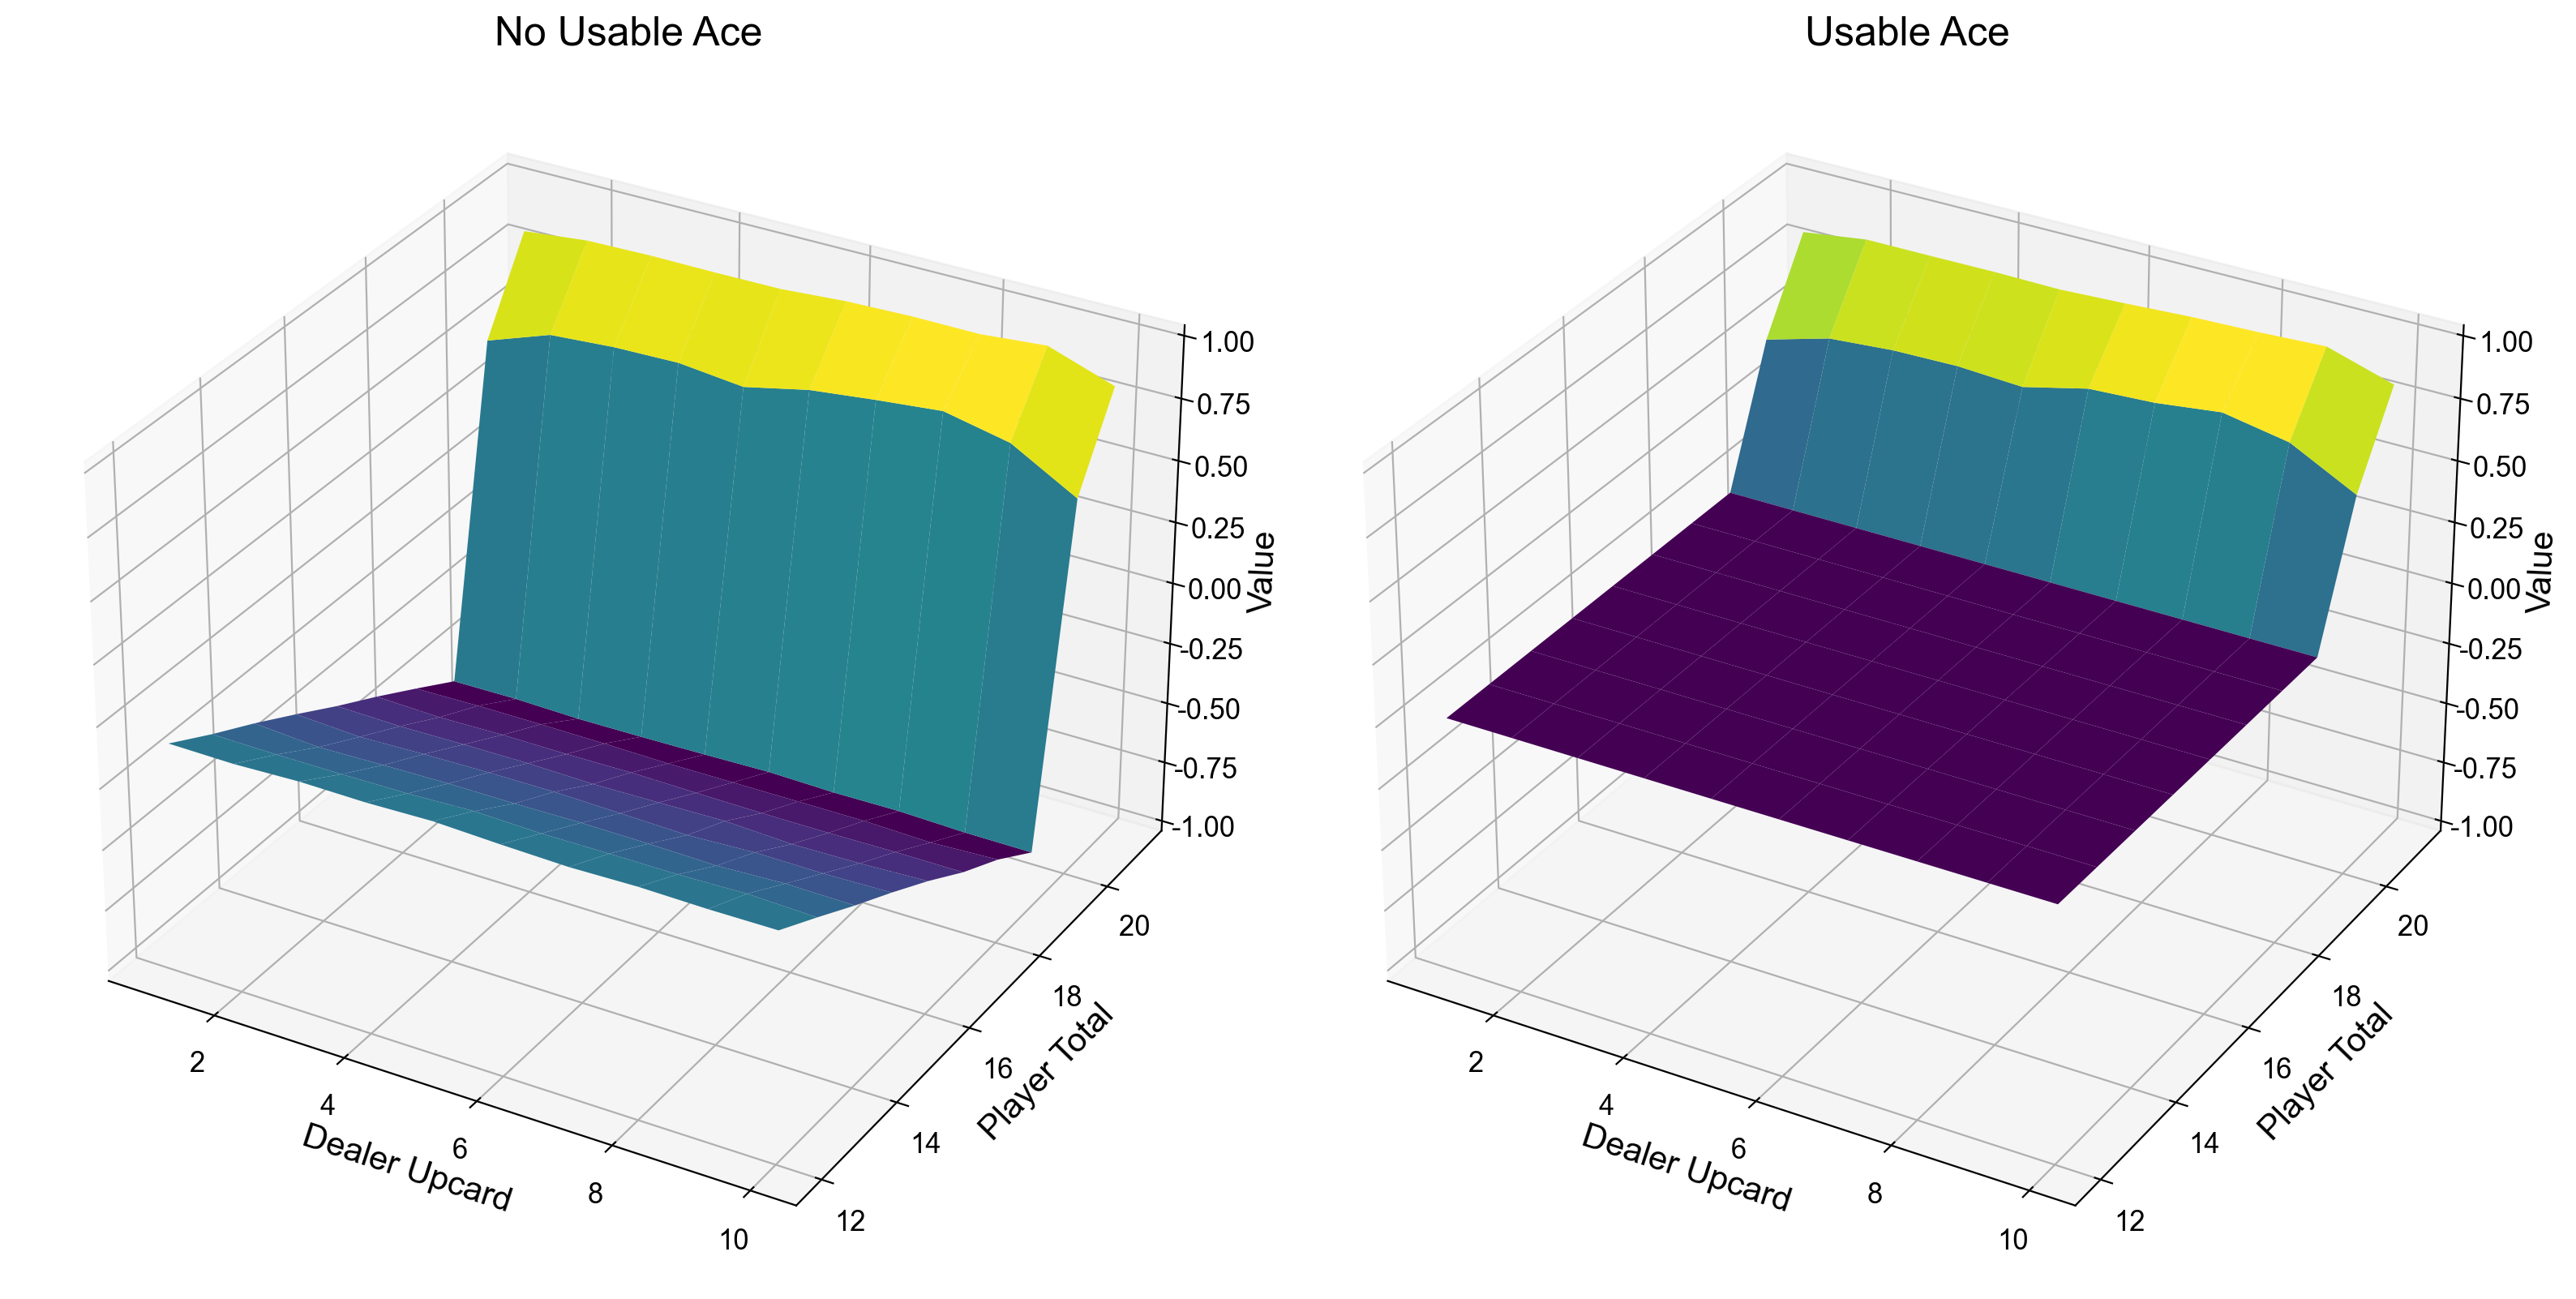

In [39]:
def draw_card():
    card = rng.integers(1, 11)
    return min(card, 10)

def draw_hand():
    return [draw_card(), draw_card()]

def step(state, action):
    player_total, dealer_upcard, usable_ace = state
    if action:
        card = draw_card()
        if card == 1 and player_total <= 10:
            player_total += 11
            usable_ace = 1
        else:
            player_total += card
        if player_total > 21 and usable_ace:
            player_total -= 10
            usable_ace = 0
        if player_total > 21:
            return (player_total, dealer_upcard, usable_ace), -1, True
        else:
            return (player_total, dealer_upcard, usable_ace), 0, False
    else:
        dealer_total = dealer_upcard
        usable_ace_dealer = dealer_upcard == 1
        while dealer_total < 17:
            card = draw_card()
            if card == 1 and dealer_total <= 10:
                dealer_total += 11
                usable_ace_dealer = True
            else:
                dealer_total += card
            if dealer_total > 21 and usable_ace_dealer:
                dealer_total -= 10
                usable_ace_dealer = False
        if dealer_total > 21:
            return (player_total, dealer_upcard, usable_ace), 1, True
        else:
            if dealer_total < player_total:
                return (player_total, dealer_upcard, usable_ace), 1, True
            elif dealer_total > player_total:
                return (player_total, dealer_upcard, usable_ace), -1, True
            else:
                return (player_total, dealer_upcard, usable_ace), 0, True

def evaluate_policy(player_policy, num_episodes=500000):
    v_sum = np.zeros((10, 10, 2)) # 12-21 by 1-10 by 0/1
    v_count = np.zeros((10, 10, 2))
    q_sum = np.zeros((10, 10, 2, 2))
    q_count = np.zeros((10, 10, 2, 2))
    for _ in range(num_episodes):
        
        state = (rng.integers(12, 22), rng.integers(1, 11), rng.integers(0, 2))
        episode = []
        done = False
        while not done:
            action = player_policy(state) # pai function
            next_state, reward, done = step(state, action)
            episode.append((state, action, reward))
            state = next_state
        
        for s, a, r in episode:
            player_total, dealer_upcard, usable_ace = s
            v_count[player_total-12, dealer_upcard-1, usable_ace] += 1
            v_sum[player_total-12, dealer_upcard-1, usable_ace] += r
            q_count[player_total-12, dealer_upcard-1, usable_ace, a] += 1
            q_sum[player_total-12, dealer_upcard-1, usable_ace, a] += r
    v = v_sum / v_count
    q = q_sum / q_count
    return v, q

def player_policy(state):
    player_total, dealer_upcard, usable_ace = state
    if player_total < 20:
        return 1 # hits
    else:
        return 0 # sticks

v, q = evaluate_policy(player_policy)

plot_value_function(v)


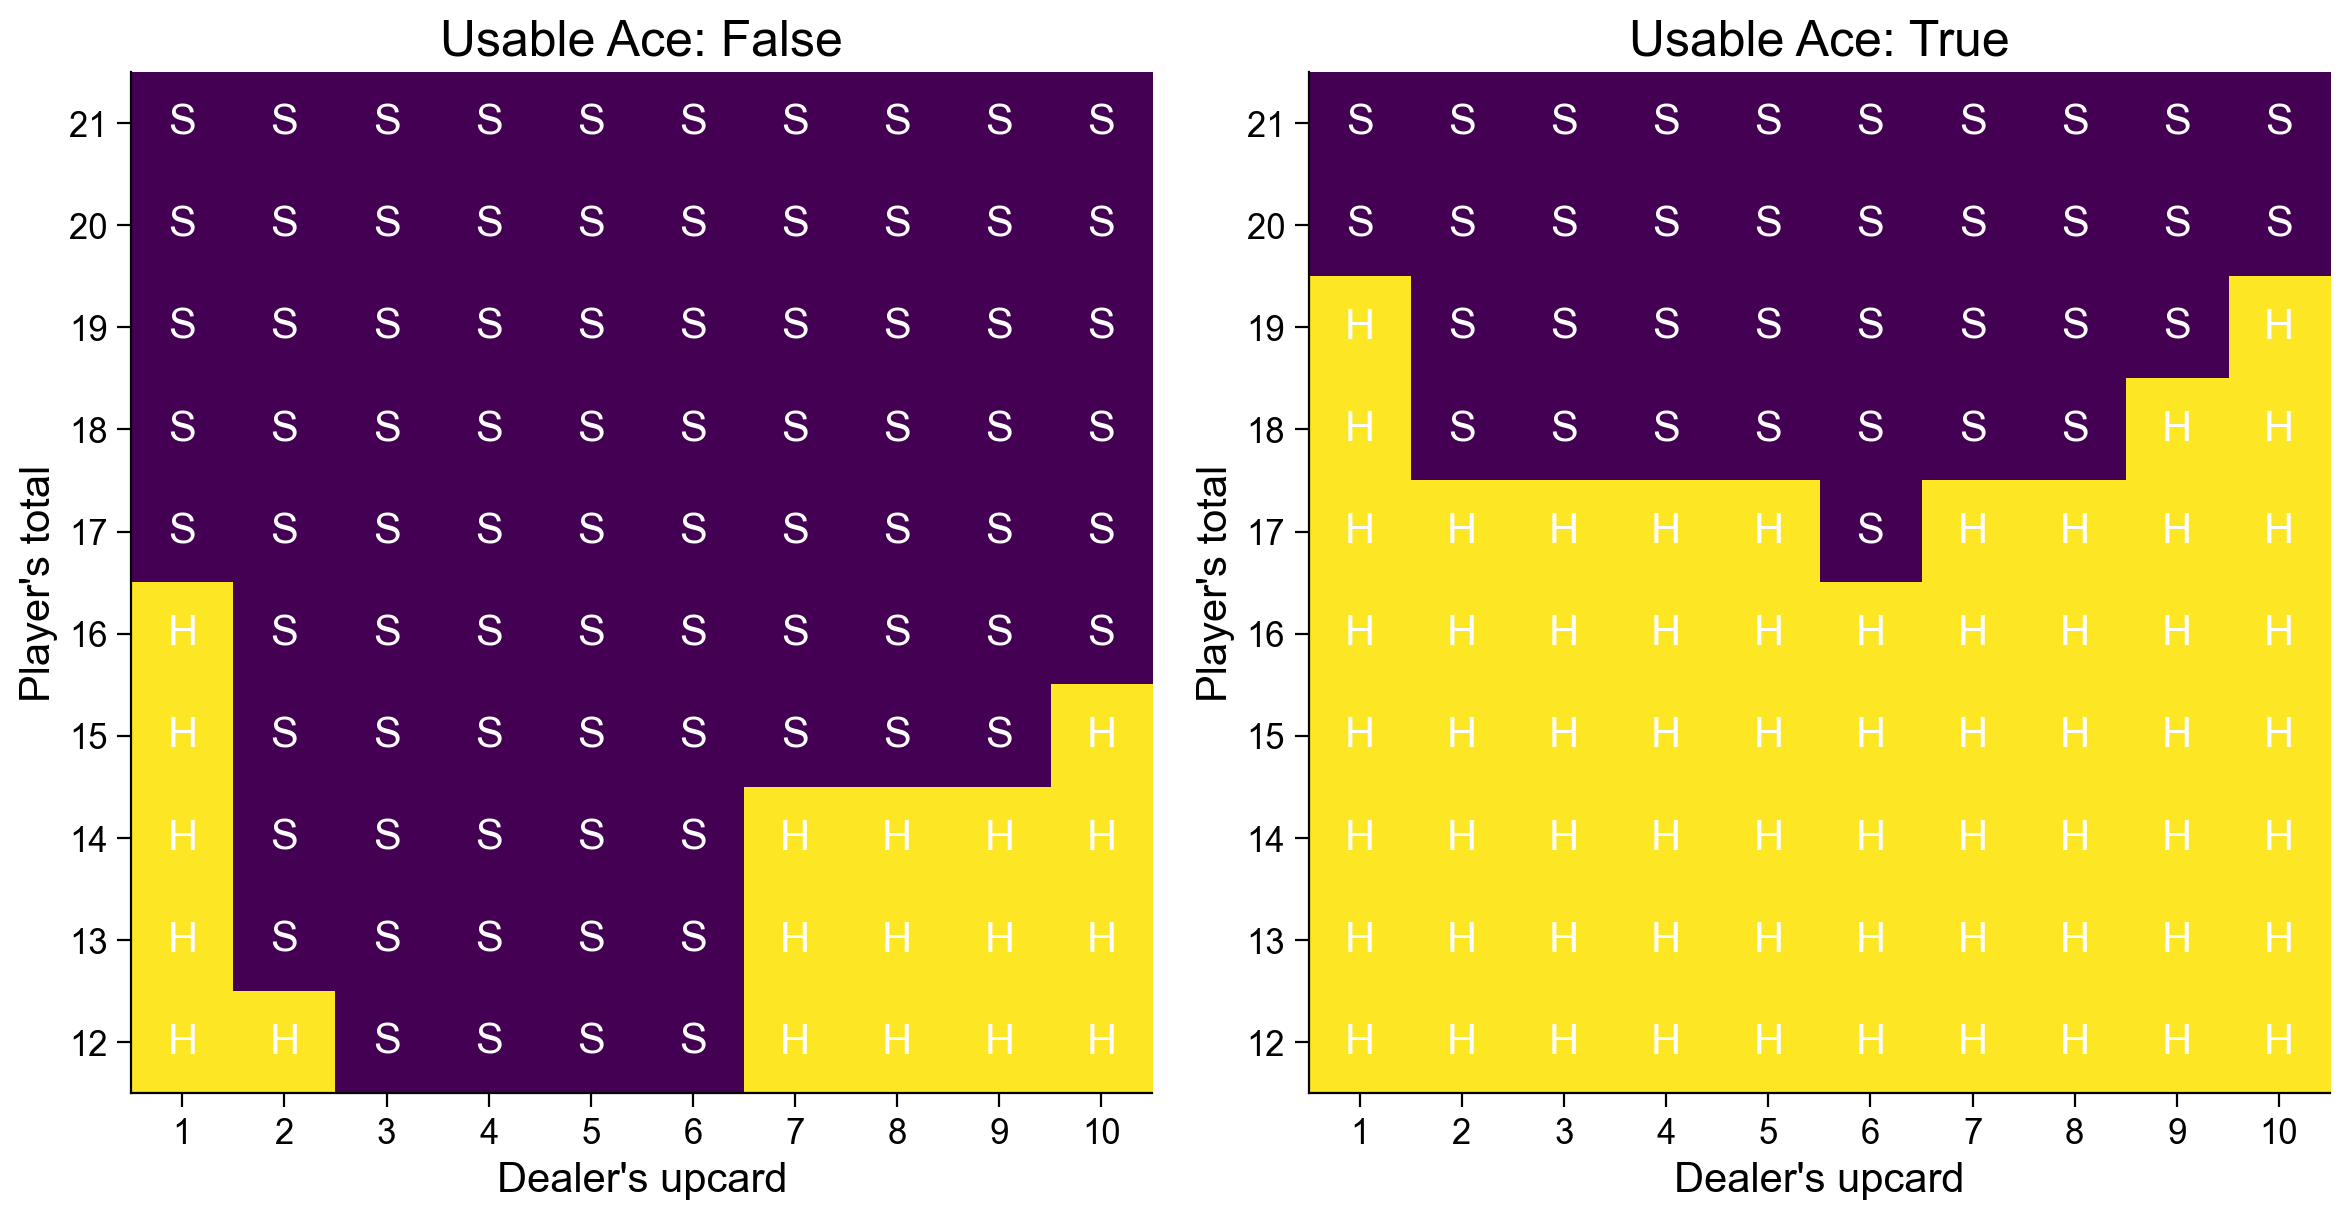

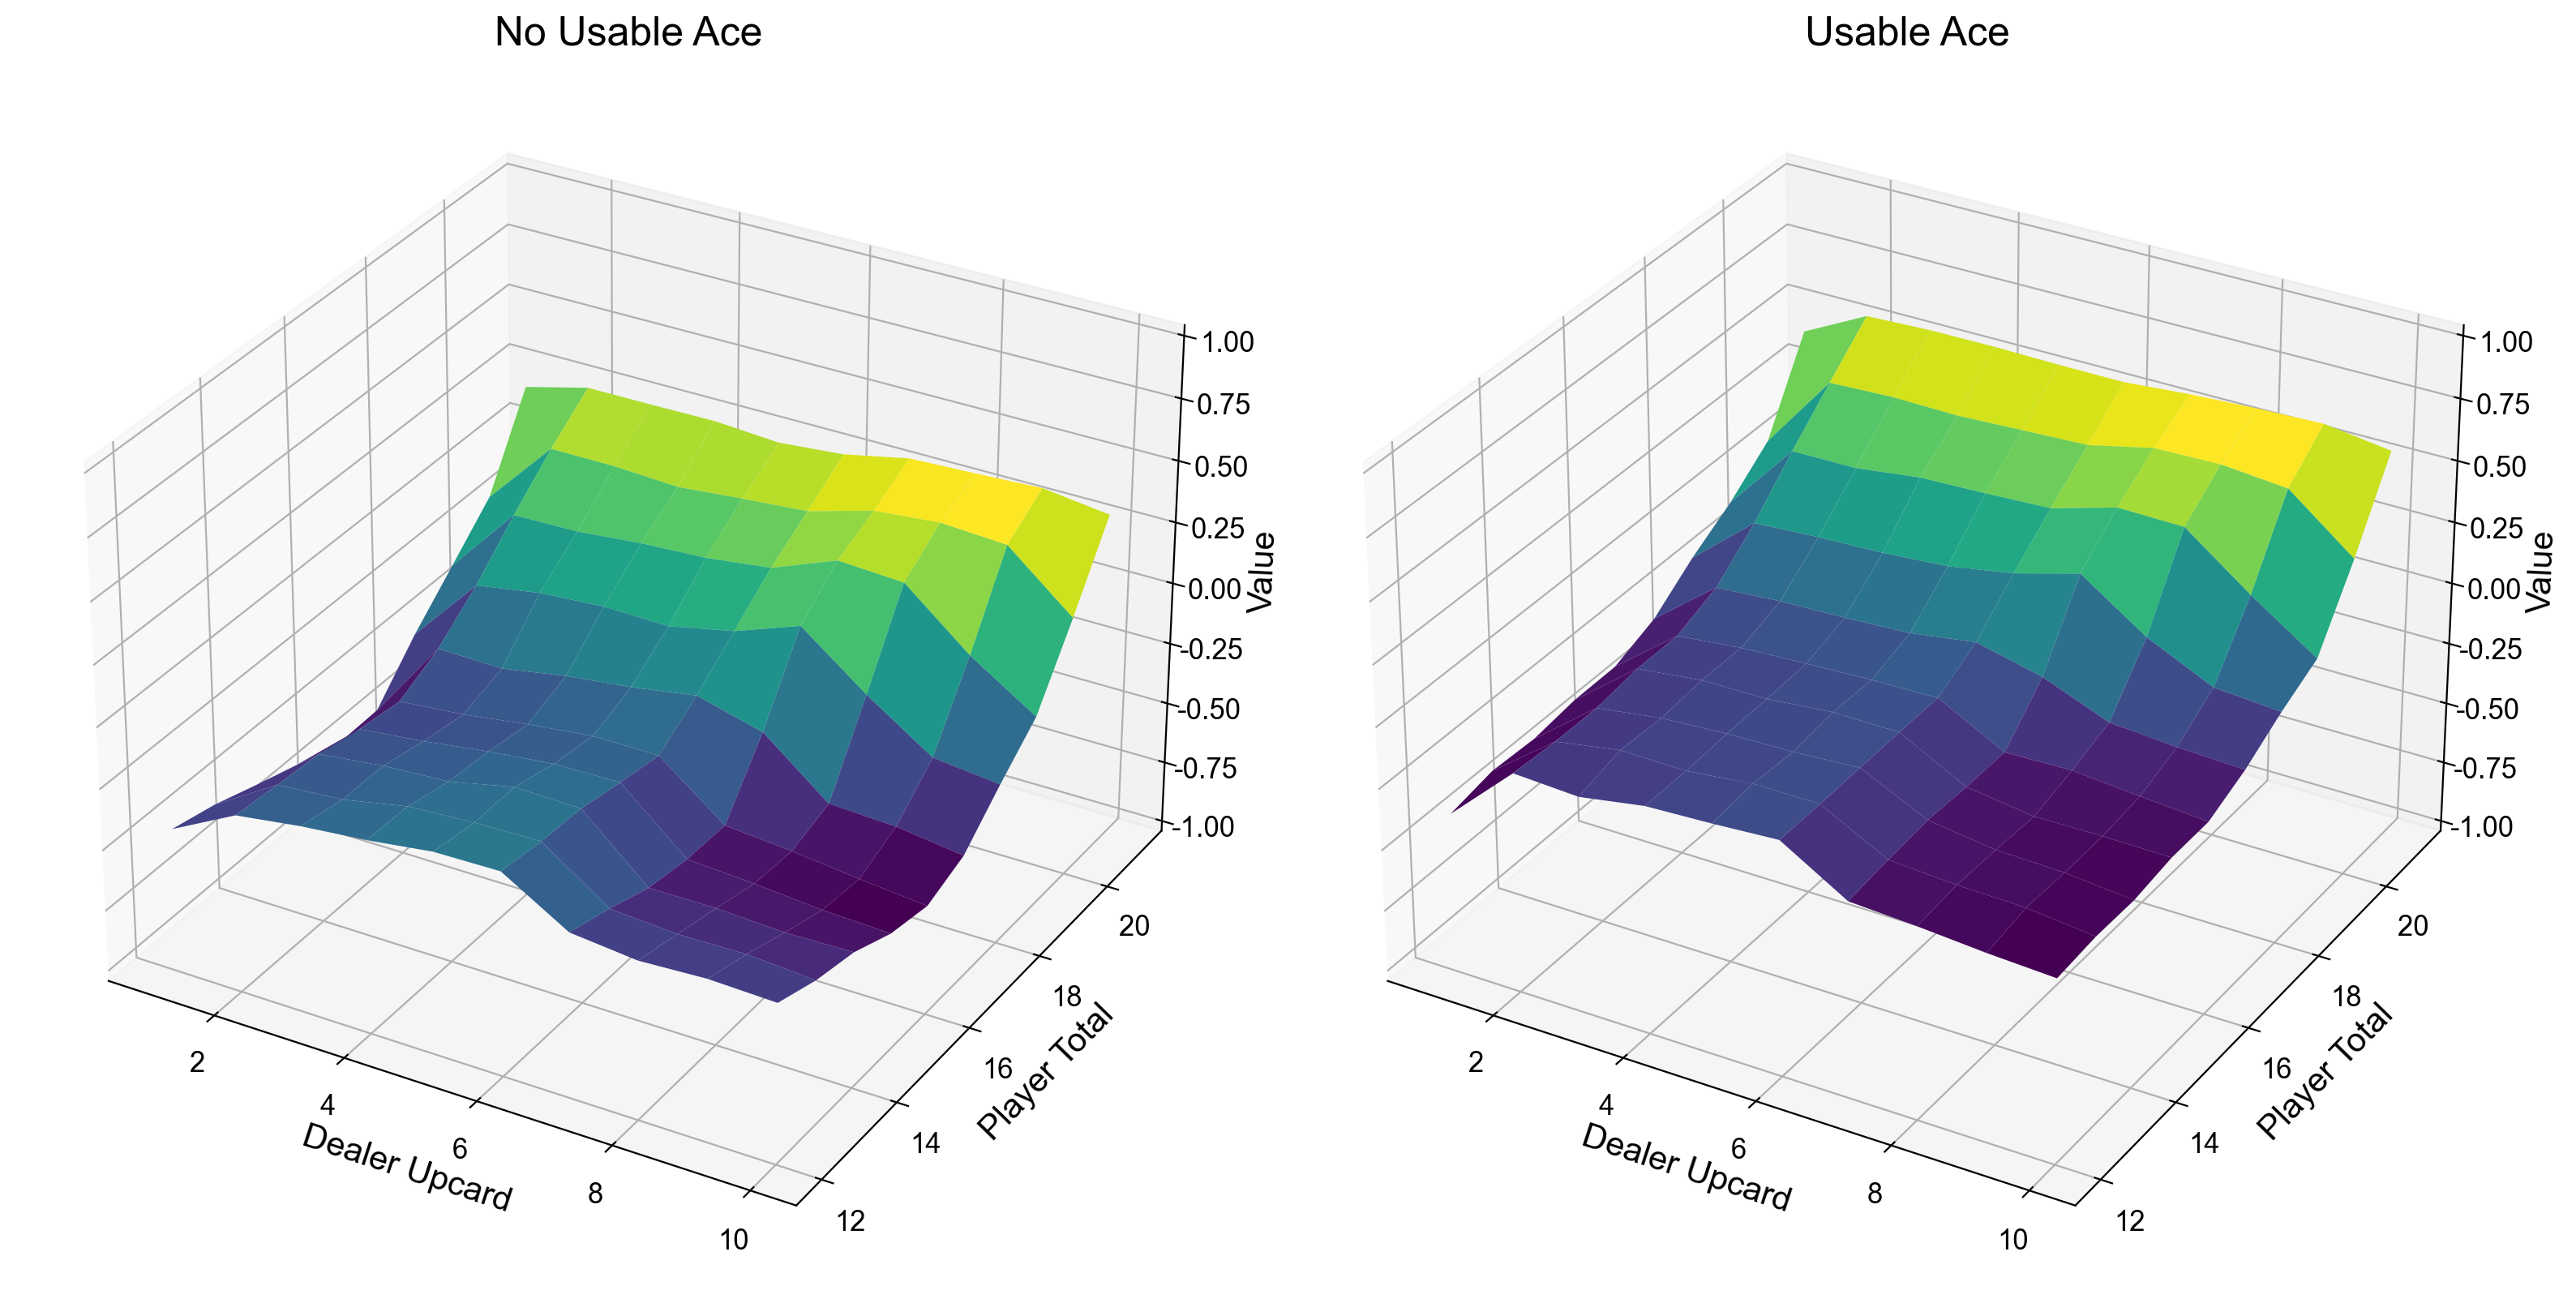

In [44]:
def draw_card():
    card = rng.integers(1, 14)
    return min(card, 10)

def draw_hand():
    return [draw_card(), draw_card()]

def step(state, action):
    player_total, dealer_upcard, usable_ace = state
    if action:
        card = draw_card()
        if card == 1 and player_total <= 10:
            player_total += 11
            usable_ace = 1
        else:
            player_total += card
        if player_total > 21 and usable_ace:
            player_total -= 10
            usable_ace = 0
        if player_total > 21:
            return (player_total, dealer_upcard, usable_ace), -1, True
        else:
            return (player_total, dealer_upcard, usable_ace), 0, False
    else:
        dealer_total = dealer_upcard if dealer_upcard != 1 else 11
        usable_ace_dealer = dealer_upcard == 1
        while dealer_total < 17:
            card = draw_card()
            if card == 1 and dealer_total <= 10:
                dealer_total += 11
                usable_ace_dealer = True
            else:
                dealer_total += card
            if dealer_total > 21 and usable_ace_dealer:
                dealer_total -= 10
                usable_ace_dealer = False
        if dealer_total > 21:
            return (player_total, dealer_upcard, usable_ace), 1, True
        else:
            if dealer_total < player_total:
                return (player_total, dealer_upcard, usable_ace), 1, True
            elif dealer_total > player_total:
                return (player_total, dealer_upcard, usable_ace), -1, True
            else:
                return (player_total, dealer_upcard, usable_ace), 0, True

def monte_carlo_es(num_episodes=1000000):

    q_sum = np.zeros((10, 10, 2, 2))
    q_count = np.zeros((10, 10, 2, 2))
    v_sum = np.zeros((10, 10, 2))
    v_count = np.zeros((10, 10, 2))
    player_policy = np.zeros((10, 10, 2), dtype=int)

    for _ in range(num_episodes):
        
        state = (rng.integers(12, 22), rng.integers(1, 11), rng.integers(0, 2))
        action = rng.integers(0, 2)
 
        episode = []
        done = False
        while True:
            next_state, reward, done = step(state, action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            action = player_policy[state[0] - 12, state[1] - 1, state[2]]
            
        
        for s, a, r in episode:
            player_total, dealer_upcard, usable_ace = s
            q_count[player_total-12, dealer_upcard-1, usable_ace, a] += 1
            q_sum[player_total-12, dealer_upcard-1, usable_ace, a] += r
            v_count[player_total-12, dealer_upcard-1, usable_ace] += 1
            v_sum[player_total-12, dealer_upcard-1, usable_ace] += r
        
        q = q_sum / (q_count + 1e-10)  # Add a small value to avoid division by zero
        v = v_sum / (v_count + 1e-10)
        player_policy = np.argmax(q, axis=-1)
    
    return player_policy, q, v

player_policy, q, v = monte_carlo_es()
plot_policy(player_policy)
plot_value_function(v)
